In [1]:
import sys
import os
import math
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.pardir)
sys.path.append(PROJECT_ROOT)


from electronTransportCode.Material import Material, WaterMaterial
from electronTransportCode.ProjectUtils import FSC, ERE
%matplotlib widget

In [2]:

Z, r0, beta, tau, mu = sy.symbols('Z, r0, beta, tau, mu')  # type: ignore
eta = sy.symbols('eta', positive=True)  # type: ignore
sigma = (sy.pi*(r0*Z)**2)/((beta**2)*tau*(tau+2)*eta*(eta+1))
dsigmadmu = (2*sy.pi*(r0*Z)**2)/((beta**2)*tau*(tau+2)*(1-mu+2*eta)**2)
pdf = dsigmadmu/sigma


In [3]:
print(pdf)
print(f'Indeed pdf is normalized: int(pdf, (mu, -1, 1)) = {sy.simplify(sy.integrate(pdf, (mu, -1, 1)))}')
exp = sy.integrate(mu*pdf, (mu, -1, 1))
print(f'Mean: {sy.simplify(exp)}')


2*eta*(eta + 1)/(2*eta - mu + 1)**2
Indeed pdf is normalized: int(pdf, (mu, -1, 1)) = 1
Mean: -eta*(2*eta + 2*(eta + 1)*log(-2*eta - 2) + 1) + (eta + 1)*(2*eta*log(-2*eta) + 2*eta + 1)


In [4]:

def getEta(Ekin: float, material: Material) -> float:
    temp = Ekin*(Ekin+2)
    betaSquared = temp/((Ekin+1)**2)
    eta0 = material.eta0CONST/temp
    return eta0*(1.13 + 3.76*((FSC*material.Z)**2)/betaSquared)

def getMeanMu(Ekin: float, material: Material) -> float:
    temp = Ekin*(Ekin+2)
    betaSquared = temp/((Ekin+1)**2)
    eta0 = material.eta0CONST/temp
    eta = eta0*(1.13 + 3.76*((FSC*material.Z)**2)/betaSquared)
    return eta*(eta+1)*(1/eta + 1/(eta+1) + 2*math.log(eta) - 2*math.log(eta+1))


In [5]:
eta = getEta(10/ERE, WaterMaterial)
muRange = np.linspace(-1, 1, 100)
pdfs = 2*eta*(eta + 1)/np.power(2*eta - muRange + 1, 2)


Text(0, 0.5, 'pdf')

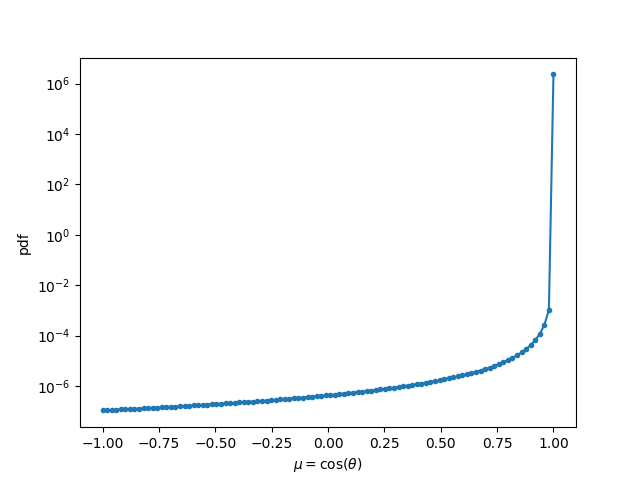

In [6]:
fig, ax = plt.subplots()
ax.semilogy(muRange, pdfs, '.-')
ax.set_xlabel('$\mu = \cos(\\theta)$')
ax.set_ylabel('pdf')

In [7]:
emin = 1e-3
emax = 21/ERE
eRange = np.linspace(emin, emax, 200)
Ecost = np.array([getMeanMu(energy, WaterMaterial) for energy in eRange], dtype=float)

Text(0, 0.5, '$E[\\cos(\\theta)]$')

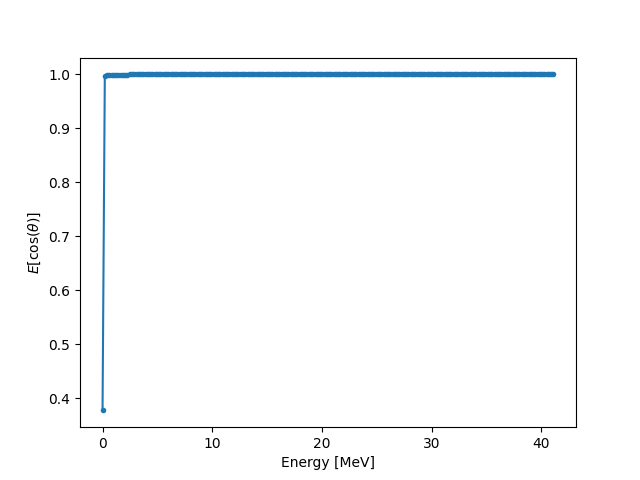

In [8]:
fig, ax = plt.subplots()
ax.plot(eRange, Ecost, '.-')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('$E[\cos(\\theta)]$')

In [9]:
Ecost

array([0.37779335, 0.99692155, 0.99846951, 0.99900997, 0.99928505,
       0.99945068, 0.99956057, 0.99963826, 0.99969574, 0.99973973,
       0.99977431, 0.99980208, 0.99982477, 0.99984359, 0.99985941,
       0.99987284, 0.99988436, 0.99989432, 0.999903  , 0.99991061,
       0.99991733, 0.9999233 , 0.99992862, 0.99993338, 0.99993767,
       0.99994155, 0.99994506, 0.99994826, 0.99995118, 0.99995385,
       0.9999563 , 0.99995855, 0.99996063, 0.99996256, 0.99996434,
       0.99996599, 0.99996753, 0.99996897, 0.9999703 , 0.99997155,
       0.99997273, 0.99997383, 0.99997486, 0.99997583, 0.99997674,
       0.9999776 , 0.99997842, 0.99997919, 0.99997992, 0.9999806 ,
       0.99998126, 0.99998188, 0.99998247, 0.99998303, 0.99998356,
       0.99998407, 0.99998455, 0.99998502, 0.99998546, 0.99998588,
       0.99998628, 0.99998667, 0.99998703, 0.99998739, 0.99998773,
       0.99998805, 0.99998836, 0.99998866, 0.99998895, 0.99998923,
       0.9999895 , 0.99998975, 0.99999   , 0.99999024, 0.99999